In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import glob
import os
import matplotlib.pyplot as plt
import math


# Load Data

In [2]:
path = 'data/csv'
files = glob.glob(os.path.join(path, '*.csv'))

li = []

for filename in files: 
    frame = pd.read_csv(filename, header=0)
    li.append(frame)

df_full = pd.concat(li, axis=0, ignore_index=True)
# df= pd.read_csv('data/out_test.csv')

C:\Users\hanna\AppData\Local\Temp/ipykernel_12324/2750601218.py:7: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(filename, header=0)


In [5]:
df = df_full.sample(n=10000)

# Data exploration and Cleaning

### Subject labels

The subject labels and types are saved as a string using '|' as seperator

In [6]:
# documents without subjects

without_subject = df.subjects.isnull().sum() * 100 / len(df)
print("Percentage of documents without subjects: {0:.2f}% ".format(without_subject))

Percentage of documents without subjects: 63.82% 


In [7]:
# drop documents without subject labels

df.dropna(subset=['subjects'], inplace=True)
df['subjects'].isna().sum()

0

In [8]:
# cleaning the subject types
subject_list = df['subject_types'].str.split('|')

# cleaning up the subject: getting rid of commas and spaces, replacing the | with spaces
df['subject_list'] = df['subjects'].apply(lambda x: str(x).replace(',', '').replace(' ', '').replace('|', ' '))

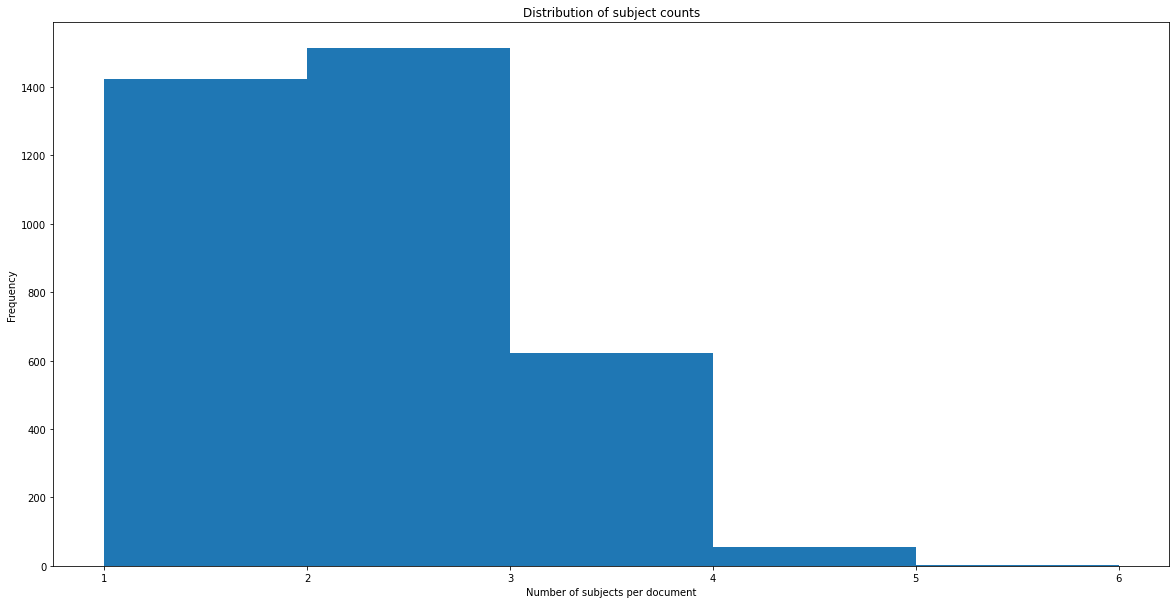

In [9]:
# how many subjects per document

counts = df.subjects.apply(lambda x : len(str(x).split('|')))

# plot a histogram of the counts

fig = plt.figure(figsize=(20, 10))
plt.hist(counts, bins=range(1, max(counts) + 2))
plt.xlabel('Number of subjects per document')
plt.ylabel('Frequency')
plt.title('Distribution of subject counts')
plt.show()


### ParentIds

- Volumes with parentid: Volumes of works have a parent entry in the bvb catalogue, all the children point to it in the parentid field. If the documents are present in the BH, the children have a shelf number, the parent document doesn't. Often neither contain subjects (as they are e.g. encyclopedias)

In [10]:
#parentids

grouped = df.groupby('parentId').size()


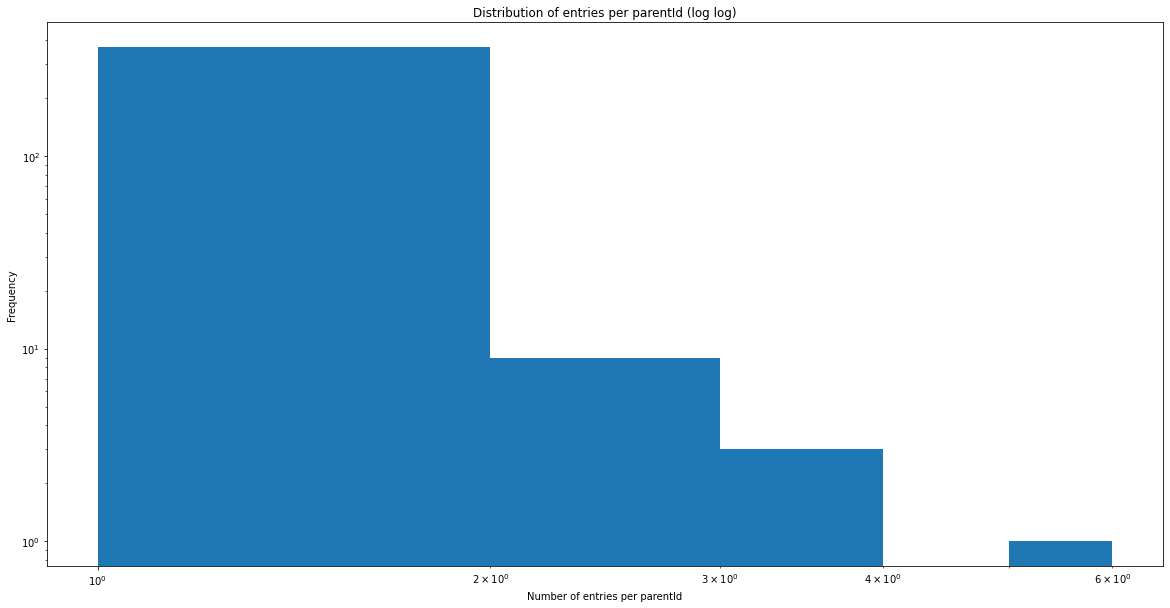

In [11]:
# plot a histogram of the size values on a log log plot to show the power law

fig = plt.figure(figsize=(20, 10))
plt.hist(grouped, bins=range(1, max(grouped) + 2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of entries per parentId')
plt.ylabel('Frequency')
plt.title('Distribution of entries per parentId (log log)')
plt.show()


The volume with most entries is an auction catalogue: Christie, Manson & Woods

In [12]:
max_id = grouped.idxmax()
df[df.parentId == max_id].head()

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,...,text,text_3,text_2,text_1,lev,sys,numbis,vw,backreference,subject_list
829334,BV038892020,ita,NaN,Santuari cristiani d'Italia,NaN,École Française de Rome ... A cura di Mario Tosti,Rome,NaN,2003,"Tosti, Mario",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Italien Wallfahrtskirche
866882,BV040145158,fre,NaN,L'héritage byzantin en Italie (VIIIe-XIIe siècle),NaN,"études réunies par Jean-Marie Martin, Annick P...",Rome,École Française de Rome,2011,"Martin, Jean-Marie|Martin, Jean-Marie|Peters-C...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Italien Urkunde
829337,BV038892023,fre,"Pelletier, Gérard",Rome et la Révolution française,NaN,NaN,Rome,École Française de Rome,2004,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KatholischeKircheSanctaSedes FranzösischeRevol...
97459,BV035275643,fre,NaN,La noblesse dans les territoires angevins à la...,NaN,réunis par Noël Coulet ...,Rome,École française de Rome,2000,"Coulet, Noël",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anjou(Familie) Territorialstaat
977953,BV044527674,fre,NaN,Les grands officiers dans les territoires ange...,NaN,études réunies par Riccardo Rao,Rome,École Française de Rome,2017,"Rao, Riccardo",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AngevinischesReich PolitischeElite


### Publication year
The year column is very messy. I'm trying to extract only the year for each 

In order to extract only the year (which is hopefully present in all rows with a publication year entry), I'm trying a regex pattern match with 4 digits exactly

In [13]:
df.year.isna().sum()

2

In [14]:
df['year_clean'] = df.year.str.extract(r'(\d{4})')
df['year_clean'] = pd.to_numeric(df['year_clean'], errors='coerce')


In [15]:
# distribution of years

grouped = df.groupby('year_clean').size()


In [16]:
funny_years = df[df.year_clean.apply(lambda x: float(x) > 2023)]
funny_years

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,...,text_3,text_2,text_1,lev,sys,numbis,vw,backreference,subject_list,year_clean


In [17]:
# drop rows that are obviously not valid years

mask = (df['year_clean'] <= 2023) & (df['year_clean'] != 0)

df= df.loc[mask]

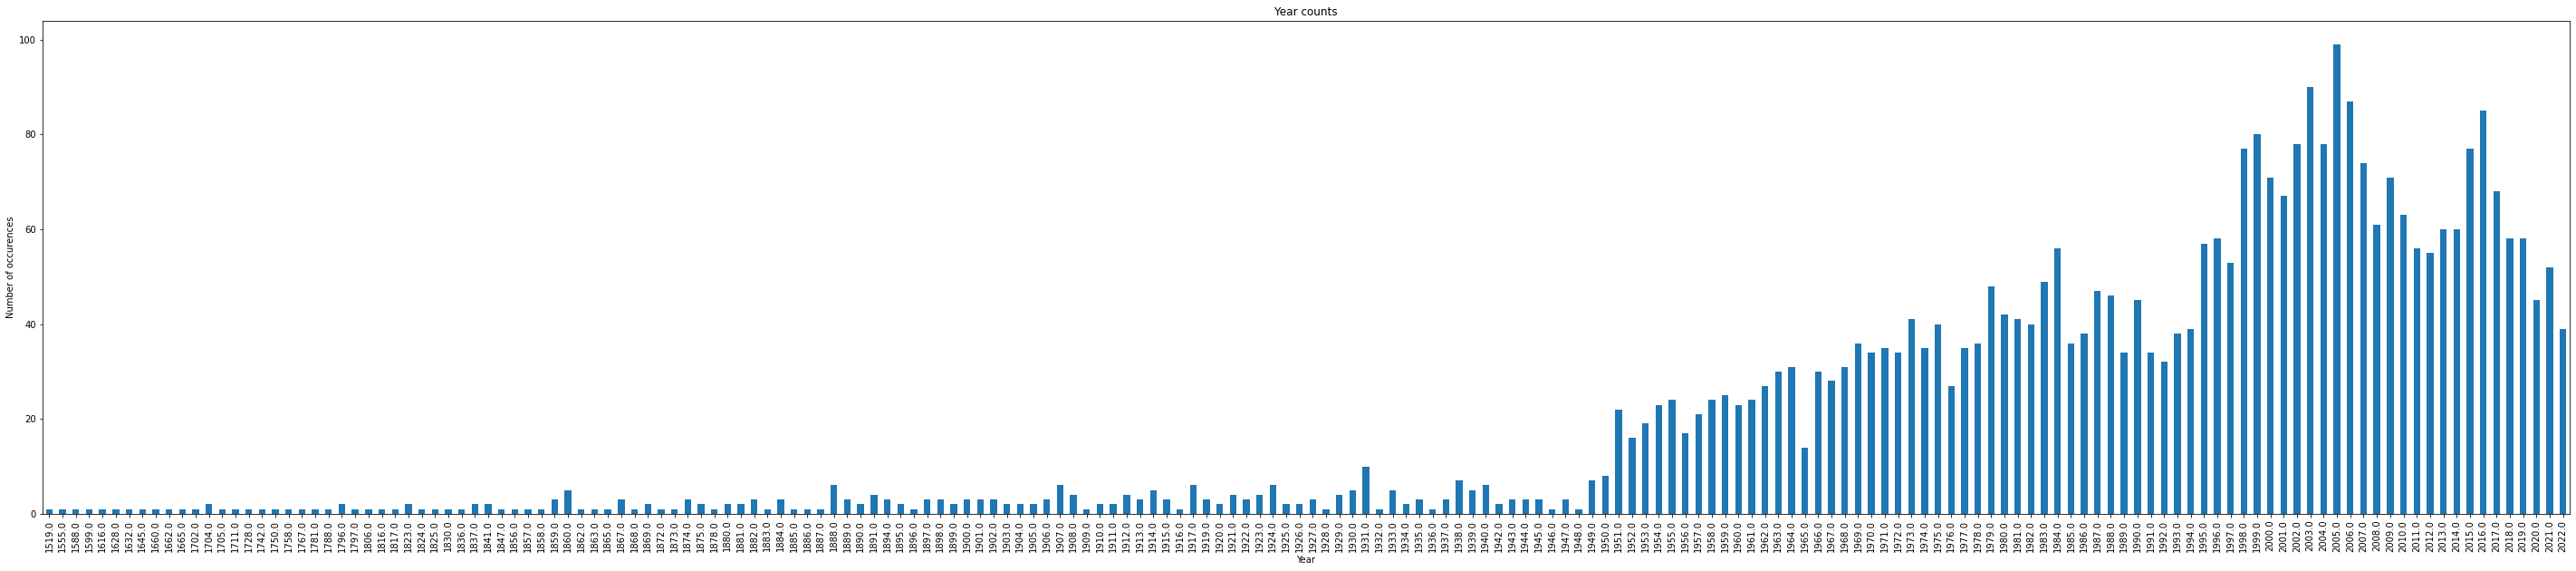

In [18]:
# distribution of years

grouped = df.groupby('year_clean').size()

fig = plt.figure(figsize=(50, 10))
grouped.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of occurences')
plt.title('Year counts')
plt.show()


In [19]:
min(grouped.index)

1519.0

In [20]:
df.to_csv('data/csv/sample_data.csv')

### Catalogue Info
- Acquisition date: before 2012 approx. the date of acquisition is in the 'Inventarnummer' field. It contains the year and the how manyth document it is in a given year (linear time information). After 2012 the date of acquisition is in the acquisition date field


## Bag of words

In [21]:
vectorizer = CountVectorizer(min_df=5)
subject_doc_matrix = vectorizer.fit_transform(df.subject_list)

In [22]:
subject_doc_matrix

<5208x253 sparse matrix of type '<class 'numpy.int64'>'
	with 4359 stored elements in Compressed Sparse Row format>

In [23]:
df[df.subject_list.apply(lambda x: len(str(x)) < 4)]

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_list,year_clean
194251,BV037798648,ita,"Ravaglioli, Armando",Roma 1870 - 1970,NaN,Armando Ravaglioli. Riprese fotografiche di Ad...,Milano,Periodici Scientifici,1970,"De Mattei, Rodolfo|Lello, Adolfo",Rom,g,NaN,NaN,Rom,1970.0
133459,BV037620127,ita,NaN,"Nolli, Vasi, Piranesi",NaN,Ministero per i Beni e le Attività Culturali ....,Roma,Artemide,2004,"Bevilacqua, Mario",Rom,g,NaN,NaN,Rom,2004.0
36073,BV008855300,ger,"Biehn, Heinz",Alte Badegemächer,NaN,Heinz Biehn,Darmstadt,Schneekluth,[ca. 1964],NaN,Bad,s,BV002790295,"Wohnkunst und Hausrat, einst und jetzt",Bad,1964.0


### UMAP

In [24]:
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import umap.plot
from pointgrid import align_points_to_grid

In [25]:
# reducer = UMAP(random_state=42, n_components = 2, metric='cosine')
reducer = UMAP(random_state=42, n_components = 2, min_dist=0.01, n_neighbors=3, metric='cosine')

# Using hellinger metric the points without neighbors are mapped to nan. 

map = reducer.fit_transform(subject_doc_matrix)



In [26]:
#problem here

#f = umap.plot.points(map)

In [27]:
map

array([[10.402251 , -1.3733352],
       [10.391602 , -1.6152878],
       [ 3.9015534, -5.8362164],
       ...,
       [ 7.5151825,  8.083345 ],
       [ 6.5121694, 10.64004  ],
       [ 7.563962 ,  8.058426 ]], dtype=float32)

In [28]:
# Normalize 

embedding = map * 100 # Multiply by 100
embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position

ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0

embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# # Set origin at the middle

ptp = np.ptp(embedding, axis=0)  
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

embedding = embedding.astype(int) # Set integer

embedding

array([[ 494, -676],
       [ 384, -604],
       [-205, -948],
       ...,
       [  82,  486],
       [  82,  723],
       [  82,  462]])

# Cluster Identification

In [29]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, cluster_selection_method ='leaf')

clusterer.fit(embedding)
clusters = clusterer.labels_

# add cluster to dataframe

df['cluster'] = clusters


In [30]:
#Grouping by cluster

values = set(clusters)
if -1 in values: values.remove(-1)

clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

# Word Clouds


In [31]:
from wordcloud import WordCloud
from PIL import Image, ImageDraw

from os import path
import multidict as multidict

from scipy.spatial import ConvexHull
from scipy import interpolate

In [32]:
test = []
test.append(df.iloc[43]['subject_list'])
test

['Kastilien Frauenkloster MonasteriodeSantaMaríalaRealdeHuelgas']

In [33]:
for index, cluster in enumerate(clusters):

    # Preprocessing

    scale = 1
    
    min_X = min([i[0] for i in embedding[cluster]]) * scale
    max_X = max([i[0] for i in embedding[cluster]]) * scale
    min_Y = min([i[1] for i in embedding[cluster]]) * scale
    max_Y = max([i[1] for i in embedding[cluster]]) * scale

    width = max_X - min_X; height = max_Y - min_Y
    
    #points = list(map(lambda i: (i[0] * scale - min_X, i[1] * scale - min_Y), embedding[cluster]))
    points = [(i[0] * scale - min_X, i[1] * scale - min_Y) for i in embedding[cluster]]

    # Hull

    hull = ConvexHull(points)

    x_hull = np.append(hull.points[hull.vertices,0], hull.points[hull.vertices,0][0])
    y_hull = np.append(hull.points[hull.vertices,1], hull.points[hull.vertices,1][0])
    
    # Interpolation
    
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)    
    interp_points = list(zip(interp_x, interp_y))

    # Create mask

    print(width, height)
    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    # draw.polygon(points, fill=(0,0,0))
    draw.polygon(interp_points, fill=(0,0,0))
    mask = np.array(img)


    # Collect text

    text = []
    for id in cluster:
        text.append(df.iloc[id]['subject_list'])
    text = ' '.join(text)
    # text = text.replace('datum', 'data')
    # text = text.replace('medium', 'media')
    dictionary = multidict.MultiDict()
    _dictionary = {}


    # Frequency

    for _word in text.split(" "):
        val = _dictionary.get(_word, 0)
        _dictionary[_word] = val + 1
    for key in _dictionary:
        dictionary.add(key, _dictionary[key])


    # Wordcloud

    max_words = math.ceil(len(dictionary)*.1)


    wc = WordCloud(
        mode = "RGBA",
        color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path = 'Lato-Regular.ttf',
        mask=mask,
        
        normalize_plurals=False,
        prefer_horizontal= 1,
        
        margin=40,

        background_color=None,
        # background_color='black',

        # max_words=max_words,
        
        min_font_size= 10,
        max_font_size= 100,
        # collocation_threshold = 20,
        relative_scaling = 0,
    )

    print(index, max_words, '-', end=' ')
    
    wc.generate_from_frequencies(dictionary) # generate word cloud
    file_path = path.join('data/' + f"{index:02}.png")
    wc.to_file('../BHVizApp/src/wordclouds/'+f"{index:02}.png") # store to file

192 94
0 8 - 260 249
1 21 - 645 331
2 17 - 507 451
3 12 - 287 214
4 11 - 754 699
5 44 - 

## Export 

In [34]:
# add coordinates to dataframe

df['embedding_x']  = embedding[:,0]
df['embedding_y']  = embedding[:,1]



df.head()

,id,lang,authors,title,subtitle,statement,place,publisher,year,editors,subjects,subject_types,parentId,parentTitle,subject_list,year_clean,cluster,embedding_x,embedding_y
726567,BV038644368,eng,"Campbell, Malcolm",An antique source for an early drawing by Piet...,NaN,Malcolm Campbell,NaN,NaN,1963,NaN,"Cortona, Pietro da|Italien|Fortleben",p|g|s,NaN,NaN,CortonaPietroda Italien Fortleben,1963.0,-1,494,-676
245724,BV037941316,ita,"Antonetto, Barbara",Se non è Michelangelo è Dio,NaN,NaN,NaN,NaN,2004,NaN,Italien|Holzplastik|Michelangelo (Buonarroti),g|s|p,NaN,NaN,Italien Holzplastik Michelangelo(Buonarroti),2004.0,-1,384,-604
262535,BV037966748,spa,"Ariza Muñoz, Carmen",El jardín dentro del jardín madrileño,NaN,NaN,NaN,NaN,1997,NaN,Madrid|Garten,g|s,NaN,NaN,Madrid Garten,1997.0,-1,-205,-948
733478,BV038655204,ita,"Cogliati Arano, Luisa",Un documento riferibile ad Andrea Solario,NaN,Luisa Cogliati Arano,NaN,NaN,1965,NaN,"Solari, Andrea",p,NaN,NaN,SolariAndrea,1965.0,4,137,201
581991,BV038416871,ger,"Kiel, Hanna","Florenz, San Lorenzo",NaN,Hanna Kiel,NaN,NaN,1977,NaN,San Lorenzo|Michelangelo (Buonarroti),g|p,NaN,NaN,SanLorenzo Michelangelo(Buonarroti),1977.0,-1,549,699


In [35]:
columns_export =['id', 'lang', 'title', 'year', 'embedding_x', 'embedding_y', 'cluster', 'subject_list']

path_out = '../BHVizApp/src/data/mapping_out_sample.csv'
#path_out = 'data/mapping_out_all.csv'

df[columns_export].to_csv(path_out, index=False)

# Appendix

## TF-IDF

In [25]:
tfidf = TfidfVectorizer(min_df=5)
tfidf_subject_matrix = tfidf.fit_transform(df.subject_list)


In [26]:
tfidf_subject_matrix

<7302x429 sparse matrix of type '<class 'numpy.float64'>'
	with 7762 stored elements in Compressed Sparse Row format>

In [27]:
tfidf_embedding = UMAP(random_state=42, n_components = 2, metric='hellinger').fit(tfidf_subject_matrix)


c:\Users\hanna\anaconda3\envs\ada\lib\site-packages\umap\umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 25045 edges.
It has fully disconnected 1145 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


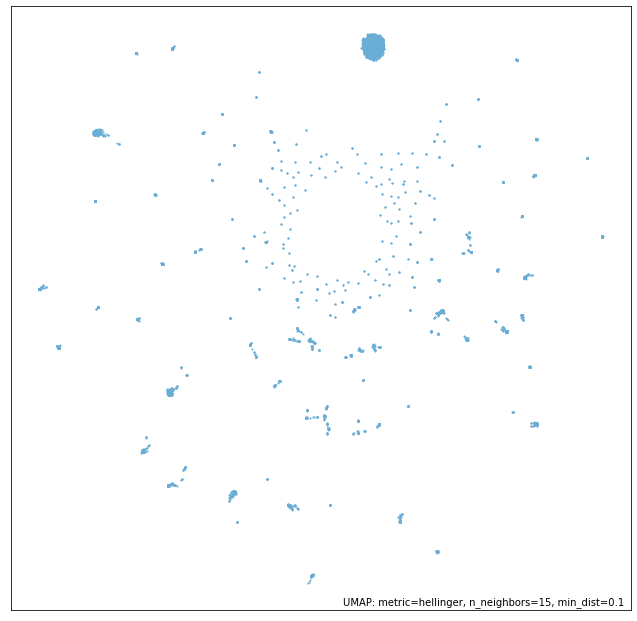

In [28]:
f = umap.plot.points(tfidf_embedding)